In [1]:
using MomentClosure, Latexify, OrdinaryDiffEq, Catalyst

┌ Info: Precompiling MomentClosure [01a1b25a-ecf0-48c5-ae58-55bfd5393600]
└ @ Base loading.jl:1278


$$ G \stackrel{c_1}{\rightarrow} G+P, \\
   G^* \stackrel{c_2}{\rightarrow} G^*+P, \\
   P \stackrel{c_3}{\rightarrow} 0 \\
   G+P \underset{c_5}{\stackrel{c_4}{\rightleftharpoons}}  G^* $$
   
On/off gene states are merged into a Bernoulli variable $g(t)$ which can be either $1$ ($G$) or $0$ ($G^*$). The number of proteins in the system is given by $p(t)$. 

### Using `ReactionSystemMod`

In [2]:
@parameters t, c₁, c₂, c₃, c₄, c₅
@variables p(t), g(t)

vars = [g, p]

ps = [c₁, c₂, c₃, c₄, c₅]

S = [0 0  0 -1 1; 
     1 1 -1 -1 1]

as = [c₁*g,     # G -> G + P
      c₂*(1-g), # G* -> G* + P
      c₃*p,     # P -> 0
      c₄*g*p,   # G+P -> G*
      c₅*(1-g)] # G* -> G+P
# system size Ω can be included as an additional parameter if needed

binary_vars = [1]

rn = ReactionSystemMod(t, vars, ps, as, S)

ReactionSystemMod(t, Term{Real,Nothing}[g(t), p(t)], Sym{ModelingToolkit.Parameter{Real},Nothing}[c₁, c₂, c₃, c₄, c₅], SymbolicUtils.Mul{Real,Int64,Dict{Any,Number},Nothing}[c₁*g(t), c₂*(1 - g(t)), c₃*p(t), c₄*g(t)*p(t), c₅*(1 - g(t))], [0 0 … -1 1; 1 1 … -1 1])

### Using Catalyst.jl `ReactionSystem`

* $\rightarrow$ indicates a reaction that follows the law of mass action (need to indicate only the reaction coefficient, full propensity function is constructed automatically)
* $\Rightarrow$ indicates a reaction that does not follow the law of mass action (need to define the full propensity function)

In [3]:
rn = @reaction_network begin
    (c₁), g → g+p
    (c₂*(1-g)), 0 ⇒ p
    (c₃), p → 0
    (c₄), g+p → 0
    (c₅*(1-g)), 0 ⇒ g+p
end c₁ c₂ c₃ c₄ c₅

Model ##ReactionSystem#253 with 5 equations
States (2):
  g(t)
  p(t)
Parameters (5):
  c₁
  c₂
  c₃
  c₄
  c₅

identical stoichiometry matrix and propensity functions are recovered

In [4]:
propensities(rn, combinatoric_ratelaw=false)

5-element Array{SymbolicUtils.Mul{Real,Int64,Dict{Any,Number},Nothing},1}:
 c₁*g(t)
 c₂*(1 - g(t))
 c₃*p(t)
 c₄*g(t)*p(t)
 c₅*(1 - g(t))

In [5]:
get_S_mat(rn)

2×5 Array{Int64,2}:
 0  0   0  -1  1
 1  1  -1  -1  1

### Moment equations

Generate raw moment equations up to 3rd order.

The argument `combinatoric_ratelaw = false` indicates whether binomial coefficients are included when constructing the propensity functions for the reactions that follow the law of mass action (does not play a role in this specific scenarion)

Equivalently, central moment equations can be generated using `generate_central_moment_eqs(rn, 3, 5, combinatoric_ratelaw=false)`

In [6]:
raw_eqs = generate_raw_moment_eqs(rn, 3, combinatoric_ratelaw=false)
latexify(raw_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& c{_5} - c{_4} \mu{_{11}} - c{_5} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& c{_2} + c{_5} + c{_1} \mu{_{10}} - c{_2} \mu{_{10}} - c{_3} \mu{_{01}} - c{_4} \mu{_{11}} - c{_5} \mu{_{10}} \\
\frac{d\mu{_{20}}}{dt} =& c{_5} + c{_4} \mu{_{11}} + c{_5} \mu{_{10}} - 2 c{_4} \mu{_{21}} - 2 c{_5} \mu{_{20}} \\
\frac{d\mu{_{11}}}{dt} =& c{_5} + c{_1} \mu{_{20}} + c{_2} \mu{_{10}} + c{_4} \mu{_{11}} + c{_5} \mu{_{01}} - c{_2} \mu{_{20}} - c{_3} \mu{_{11}} - c{_4} \mu{_{12}} - c{_4} \mu{_{21}} - c{_5} \mu{_{11}} - c{_5} \mu{_{20}} \\
\frac{d\mu{_{02}}}{dt} =& c{_2} + c{_5} + c{_1} \mu{_{10}} + c{_3} \mu{_{01}} + c{_4} \mu{_{11}} + 2 c{_1} \mu{_{11}} + 2 c{_2} \mu{_{01}} + 2 c{_5} \mu{_{01}} - c{_2} \mu{_{10}} - 2 c{_2} \mu{_{11}} - 2 c{_3} \mu{_{02}} - 2 c{_4} \mu{_{12}} - c{_5} \mu{_{10}} - 2 c{_5} \mu{_{11}} \\
\frac{d\mu{_{30}}}{dt} =& c{_5} + 3 c{_4} \mu{_{21}} + 2 c{_5} \mu{_{10}} - c{_4} \mu{_{11}} - 3 c{_4} \mu{_{31}} - 3 c{_5} \mu{_{30}} \\
\frac{d\m

We are solving for moments up to `m_order = 3`, and in the equations encounter moments up to `exp_order = 5`. 

Use the Bernoulli variable properties to eliminate redundant equations to see how they simplify:

In [7]:
bernoulli_eqs = bernoulli_moment_eqs(raw_eqs, binary_vars)
latexify(bernoulli_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& c{_5} - c{_4} \mu{_{11}} - c{_5} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& c{_2} + c{_5} + c{_1} \mu{_{10}} - c{_2} \mu{_{10}} - c{_3} \mu{_{01}} - c{_4} \mu{_{11}} - c{_5} \mu{_{10}} \\
\frac{d\mu{_{11}}}{dt} =& c{_5} + c{_1} \mu{_{10}} + c{_5} \mu{_{01}} - c{_3} \mu{_{11}} - c{_4} \mu{_{12}} - c{_5} \mu{_{10}} - c{_5} \mu{_{11}} \\
\frac{d\mu{_{02}}}{dt} =& c{_2} + c{_5} + c{_1} \mu{_{10}} + c{_3} \mu{_{01}} + c{_4} \mu{_{11}} + 2 c{_1} \mu{_{11}} + 2 c{_2} \mu{_{01}} + 2 c{_5} \mu{_{01}} - c{_2} \mu{_{10}} - 2 c{_2} \mu{_{11}} - 2 c{_3} \mu{_{02}} - 2 c{_4} \mu{_{12}} - c{_5} \mu{_{10}} - 2 c{_5} \mu{_{11}} \\
\frac{d\mu{_{12}}}{dt} =& c{_5} + c{_1} \mu{_{10}} + c{_3} \mu{_{11}} + c{_5} \mu{_{02}} + 2 c{_1} \mu{_{11}} + 2 c{_5} \mu{_{01}} - 2 c{_3} \mu{_{12}} - c{_4} \mu{_{13}} - c{_5} \mu{_{10}} - 2 c{_5} \mu{_{11}} - c{_5} \mu{_{12}} \\
\frac{d\mu{_{03}}}{dt} =& c{_2} + c{_5} + c{_1} \mu{_{10}} + 3 c{_1} \mu{_{11}} + 3 c{_1} \mu{_{12}} + 3 

### Closing the moment equations

Finally, we can apply the selected moment closure method on the system of raw moment equations:

In [8]:
closed_raw_eqs = moment_closure(raw_eqs, "conditional derivative matching", binary_vars)
latexify(closed_raw_eqs)

L"\begin{align*}
\frac{d\mu{_{10}}}{dt} =& c{_5} - c{_4} \mu{_{11}} - c{_5} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& c{_2} + c{_5} + c{_1} \mu{_{10}} - c{_2} \mu{_{10}} - c{_3} \mu{_{01}} - c{_4} \mu{_{11}} - c{_5} \mu{_{10}} \\
\frac{d\mu{_{11}}}{dt} =& c{_5} + c{_1} \mu{_{10}} + c{_5} \mu{_{01}} - c{_3} \mu{_{11}} - c{_4} \mu{_{12}} - c{_5} \mu{_{10}} - c{_5} \mu{_{11}} \\
\frac{d\mu{_{02}}}{dt} =& c{_2} + c{_5} + c{_1} \mu{_{10}} + c{_3} \mu{_{01}} + c{_4} \mu{_{11}} + 2 c{_1} \mu{_{11}} + 2 c{_2} \mu{_{01}} + 2 c{_5} \mu{_{01}} - c{_2} \mu{_{10}} - 2 c{_2} \mu{_{11}} - 2 c{_3} \mu{_{02}} - 2 c{_4} \mu{_{12}} - c{_5} \mu{_{10}} - 2 c{_5} \mu{_{11}} \\
\frac{d\mu{_{12}}}{dt} =& c{_5} + c{_1} \mu{_{10}} + c{_3} \mu{_{11}} + c{_5} \mu{_{02}} + 2 c{_1} \mu{_{11}} + 2 c{_5} \mu{_{01}} - 2 c{_3} \mu{_{12}} - c{_5} \mu{_{10}} - 2 c{_5} \mu{_{11}} - c{_5} \mu{_{12}} - c{_4} \mu{_{10}} \mu{_{11}}^{-3} \mu{_{12}}^{3} \\
\frac{d\mu{_{03}}}{dt} =& c{_2} + c{_5} + c{_1} \mu{_{10}} + 3 c{_1} \mu{_

We can also print out the closure functions for each higher order moment:

In [9]:
latexify(closed_raw_eqs, :closure)

L"\begin{align*}
\mu{_{13}} =& \mu{_{10}} \mu{_{11}}^{-3} \mu{_{12}}^{3} \\
\mu{_{04}} =& \mu{_{01}}^{4} \mu{_{02}}^{-6} \mu{_{03}}^{4}
\end{align*}
"

### Numerical solution

The closed moment equations can be solved using DifferentialEquations.jl (or just OrdinaryDiffEq.jl which is more lightweight and sufficient for this particular case. 

In [10]:
# PARAMETER INITIALISATION
pmap = [c₁ => 0.01,
        c₂ => 40,
        c₃ => 1,
        c₄ => 1,
        c₅ => 1]

# DETERMINISTIC INITIAL CONDITIONS
μ₀ = [1., 0.001]
u₀map = deterministic_IC(μ₀, closed_raw_eqs)

# time interval to solve on
tspan = (0., 1000.0)
dt = 1

@time oprob = ODEProblem(closed_raw_eqs, u₀map, tspan, pmap);
@time sol_CDM = solve(oprob, Tsit5(), saveat=dt);

 12.183509 seconds (17.83 M allocations: 933.692 MiB, 2.85% gc time)
  5.671233 seconds (12.59 M allocations: 608.756 MiB, 11.10% gc time)


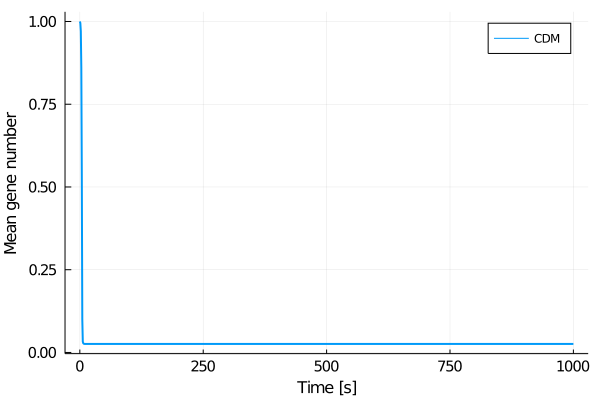

In [11]:
using Plots

plot(sol_CDM.t, sol_CDM[1,:], 
    label  = "CDM", 
    legend = true,
    xlabel = "Time [s]",
    ylabel = "Mean gene number",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

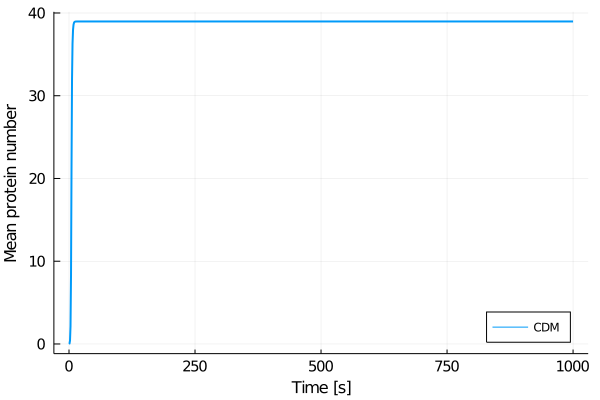

In [12]:
plot(sol_CDM.t, sol_CDM[2,:], 
    label  = "CDM",
    legend = :bottomright,
    xlabel = "Time [s]",
    ylabel = "Mean protein number",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

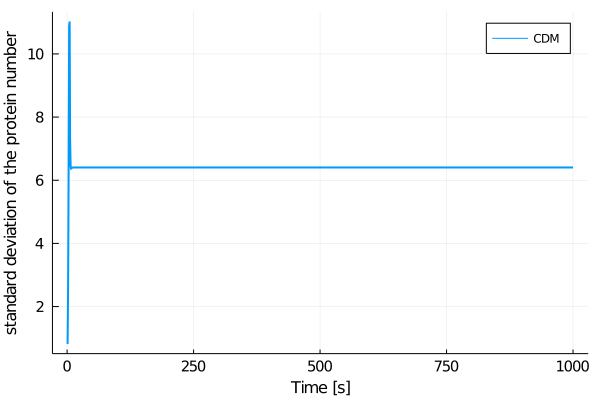

In [13]:
std_CDM = sqrt.(sol_CDM[4,2:end] .- sol_CDM[2,2:end].^2)
plot(sol_CDM.t[2:end], std_CDM, 
    label  = "CDM", 
    legend = true,
    xlabel = "Time [s]",
    ylabel = "standard deviation of the protein number",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

### SSA

In [14]:
using DiffEqJump

# parameters [c₁, c₂, c₃, c₄, c₅]
p = [param[2] for param in pmap]

# initial conditions [g, p]
# NOTE: define as FLOATS as otherwise will encounter problems due to parsing from Int to Float
u₀ = [1., 0.]

# time interval to solve on
tspan = (0., 1000.)

# create a discrete problem to encode that our species are integer valued
dprob = DiscreteProblem(rn, u₀, tspan, p)

# create a JumpProblem and specify Gillespie's Direct Method as the solver:
jprob = JumpProblem(rn, dprob, Direct(), save_positions=(false, false))
# SET save_positions to (false, false) as otherwise time of each reaction occurence is saved

dt = 1 # time resolution at which numerical solution is saved

# solve and plot
ensembleprob  = EnsembleProblem(jprob)
@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=dt, trajectories=10000);

205.463844 seconds (646.80 M allocations: 15.332 GiB, 56.95% gc time)


In [15]:
using DiffEqJump


# This is not equal to μ₀ as the initial values should be Int (not 0.001)
# However, these still must be defined as Floats, otherwise will encounter 
# problems due to parsing from Int to Float using EnsembleAnalysis
u₀ = [1., 0.]
# create a discrete problem to encode that our species are integer valued
dprob = DiscreteProblem(rn, u₀, tspan, pmap)

# create a JumpProblem and specify Gillespie's Direct Method as the solver:
jprob = JumpProblem(rn, dprob, Direct(), save_positions=(false, false))
# SET save_positions to (false, false) as otherwise time of each reaction occurence is saved

dt = 1 # time resolution at which numerical solution is saved

# solve and plot
ensembleprob  = EnsembleProblem(jprob)
@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=dt, trajectories=10000);

245.071448 seconds (645.00 M allocations: 15.269 GiB, 65.19% gc time)


Can compute all sample moments up to chosen order

In [16]:
@time SSA_μ = sample_raw_moments(sol_SSA, 2);
@time SSA_M = sample_central_moments(sol_SSA, 2);

  6.137514 seconds (2.82 M allocations: 1.325 GiB, 21.46% gc time)
  2.501856 seconds (2.79 M allocations: 744.488 MiB)


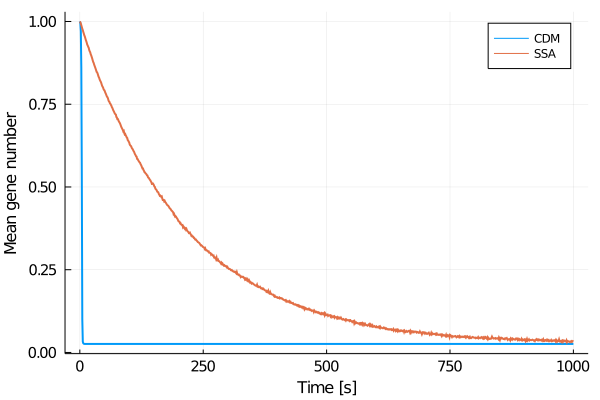

In [17]:
plot(sol_CDM.t, [sol_CDM[1,:], SSA_μ[1,0]], 
    label  = ["CDM" "SSA"], 
    legend = true,
    xlabel = "Time [s]",
    ylabel = "Mean gene number",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

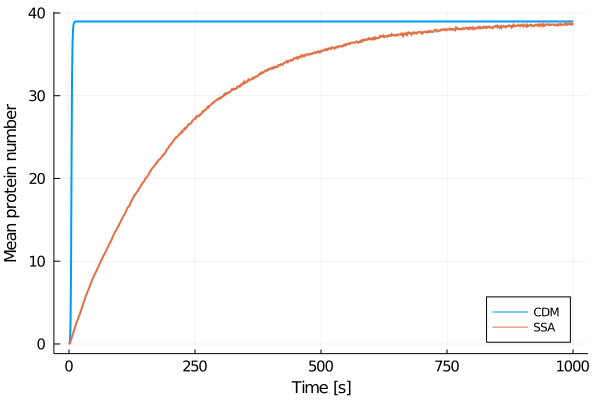

In [18]:
plot(sol_CDM.t, [sol_CDM[2,:], SSA_μ[0,1]], 
    label  = ["CDM" "SSA"],
    legend = :bottomright,
    xlabel = "Time [s]",
    ylabel = "Mean protein number",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

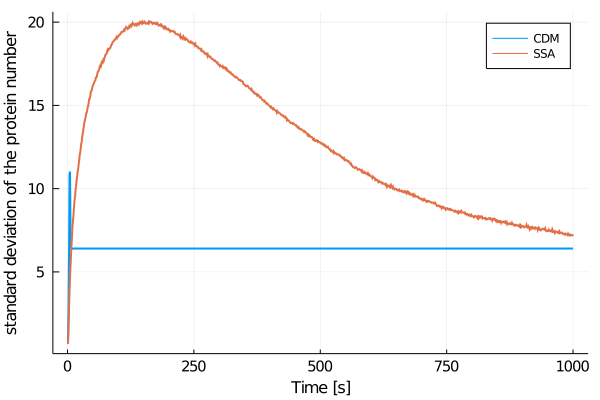

In [19]:
std_CDM = sqrt.(sol_CDM[4,2:end] .- sol_CDM[2,2:end].^2)
std_p_SSA = sqrt.(SSA_M[0,2][2:end])
plot(sol_CDM.t[2:end], [std_CDM, std_p_SSA], 
    label  = ["CDM" "SSA"], 
    legend = true,
    xlabel = "Time [s]",
    ylabel = "standard deviation of the protein number",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)